In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
import os, sys
from pathlib import Path
BASE_DIR = Path('.').resolve().parent.parent
os.chdir(BASE_DIR)
from phm08ds.models import experiment

## Load Dataset

In [4]:
folderpath = './phm08ds/data/files/'
data_completed = pd.read_csv(folderpath + 'data_preprocessed.csv')
print(data_completed.shape)
data_completed.head()

(45918, 28)


,unit,time_step,operational_setting_1,operational_setting_2,operational_setting_3,Sensor_0,Sensor_1,Sensor_2,Sensor_3,Sensor_4,...,Sensor_13,Sensor_14,Sensor_15,Sensor_16,Sensor_17,Sensor_18,Sensor_19,Sensor_20,Health_state,Operational_condition
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735,1,1
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619,1,3
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555,1,4
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832,1,2
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025,1,4


## Data preprocessing

Use the pipeline and mlp

In [5]:
from phm08ds.data.preprocessing import OperationalCondition
data_unlabel = data_completed.drop(labels=['Health_state', 'Operational_condition'], axis=1)
tf_op_cond = OperationalCondition()
op_cond = tf_op_cond.fit_transform(data_unlabel.loc[0])

from phm08ds.features.feature_selection import RemoveSensor
tf_select_sensor = RemoveSensor(sensors=[1,2,3,6,8,10,11,12,13,14,19,20])
data_important_sensors = tf_select_sensor.fit_transform(data_unlabel).iloc[:,5:]

from sklearn.preprocessing import StandardScaler
tf_std = StandardScaler()
data_elman = tf_std.fit_transform(data_important_sensors)

In [6]:
data_elman

array([[ 0.61180613,  0.68653509,  0.71411803, ...,  0.7079022 ,
         0.62225216,  0.41984362],
       [ 1.73123631,  1.81691912,  1.83668347, ...,  1.5341318 ,
         1.09585304,  0.41984362],
       [-0.88517663, -0.70301017, -0.65974064, ..., -0.51348069,
        -0.03667081,  0.41984362],
       ...,
       [-1.05297778, -1.13586454, -1.0779513 , ..., -0.51348069,
        -0.1121724 ,  0.41984362],
       [-0.88517663, -0.70301017, -0.65974064, ..., -0.40571161,
        -0.03667081,  0.41984362],
       [-0.39008766, -0.27015579, -0.47081215, ..., -1.37563332,
        -2.15071532, -2.3818392 ]])

In [7]:
labels = np.array(data_completed['Health_state'])

In [8]:
from sklearn.preprocessing import LabelEncoder
tf_label_encoder = LabelEncoder()

In [9]:
labels = tf_label_encoder.fit_transform(labels) + 1
labels = labels.reshape(labels.shape[0],1)
labels 

array([[1],
       [1],
       [1],
       ...,
       [4],
       [4],
       [4]])

# Classification steps

## How to use Elman network of neurolab

Folllowing the example at https://pythonhosted.org/neurolab/ex_newelm.html

In [14]:
import neurolab as nl

In [10]:
min_list = []
max_list = []

for feature in range(0,data_elman.shape[1]):
    min_list.append(data_elman[:,feature].min())
    max_list.append(data_elman[:,feature].max())
    
min_max_list = list(map(list, list(zip(min_list, max_list))))
min_max_list

[[-1.0529777759307313, 1.7312363125165662],
 [-1.1358645396673506, 1.8169191224769112],
 [-1.0797855524444744, 1.8366834680259683],
 [-2.1538354187812554, 1.098730161182202],
 [-1.2905496553802565, 1.6039106409075758],
 [-0.7104703701161955, 1.407518233077691],
 [-1.6270945046492944, 1.7855929859754065],
 [-2.1507153249002773, 1.0958530395659347],
 [-2.3818391992796486, 0.4198436234916414]]

In [12]:
from sklearn.preprocessing import LabelBinarizer
target_tf = LabelBinarizer()
labels_encoded = target_tf.fit_transform(labels)

In [15]:
elman_clf = nl.net.newelm(min_max_list, [50,1], [nl.trans.TanSig(), nl.trans.PureLin()])

In [16]:
# Set initialized functions and init
elman_clf.layers[0].initf = nl.init.InitRand([-0.1, 0.1], 'wb')
elman_clf.layers[1].initf= nl.init.InitRand([-0.1, 0.1], 'wb')
elman_clf.init()

In [17]:
# Train network
error = elman_clf.train(data_elman, labels, epochs=1, goal=0.1, adapt=True, show=1)
# Simulate network
output = elman_clf.sim(data_elman)

Epoch: 1; Error: 1.4986736271212189;
The maximum number of train epochs is reached


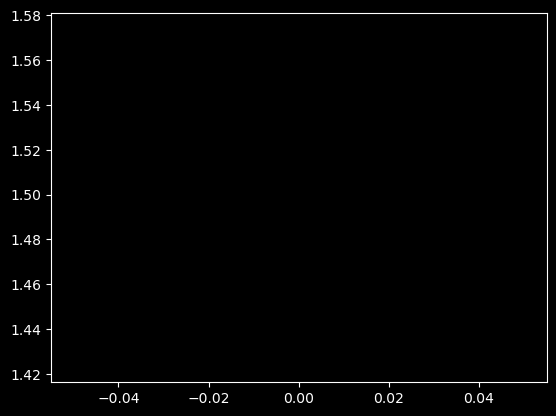

In [18]:
plt.plot(error)

### Test the newtwork

In [19]:
real_targets = labels.reshape(-1)
real_targets

array([1, 1, 1, ..., 4, 4, 4])

In [20]:
new_output = []

for k in range(0,len(output)):
    new_output.append(int(output[k].round()))

In [21]:
predicted_targets = np.array(new_output)

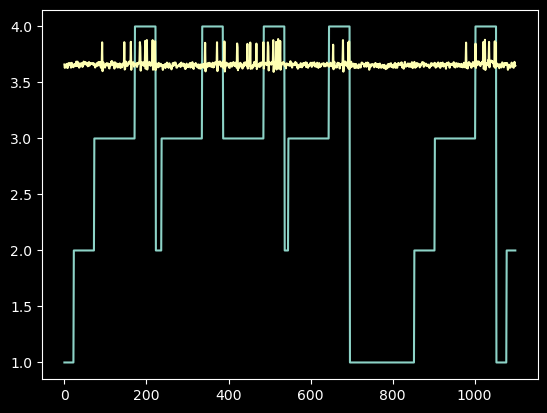

In [22]:
until_to = 1100

plt.figure()
plt.plot(real_targets[:until_to])
plt.plot(output[:until_to])

In [23]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [24]:
accuracy_score(real_targets, predicted_targets)

0.24212727035149614

In [25]:
confusion_matrix(real_targets, predicted_targets)

array([[    0,     0,     0,  5055],
       [    0,     0,     0,  8278],
       [    0,     0,     0, 21467],
       [    0,     0,     0, 11118]])